# Chapter 9. Markov Chain Monte Carlo

In [1]:
import inspect
import math
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, ops, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import ELBO, MCMC, NUTS, SVI, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
numpyro.set_host_device_count(4)

### Code 9.1

In [2]:
num_weeks = int(1e5)
positions = jnp.repeat(0, num_weeks)
current = 10


def body_fn(i, val):
    positions, current = val
    # record current position
    positions = ops.index_update(positions, i, current)

    # flip coin to generate proposal
    bern = dist.Bernoulli(0.5).sample(random.fold_in(random.PRNGKey(0), i))
    proposal = current + (bern * 2 - 1)
    # now make sure he loops around the archipelago
    proposal = jnp.where(proposal < 1, 10, proposal)
    proposal = jnp.where(proposal > 10, 1, proposal)

    # move?
    prob_move = proposal / current
    unif = dist.Uniform().sample(random.fold_in(random.PRNGKey(1), i))
    current = jnp.where(unif < prob_move, proposal, current)
    return positions, current


positions, current = lax.fori_loop(0, num_weeks, body_fn, (positions, current))

### Code 9.2

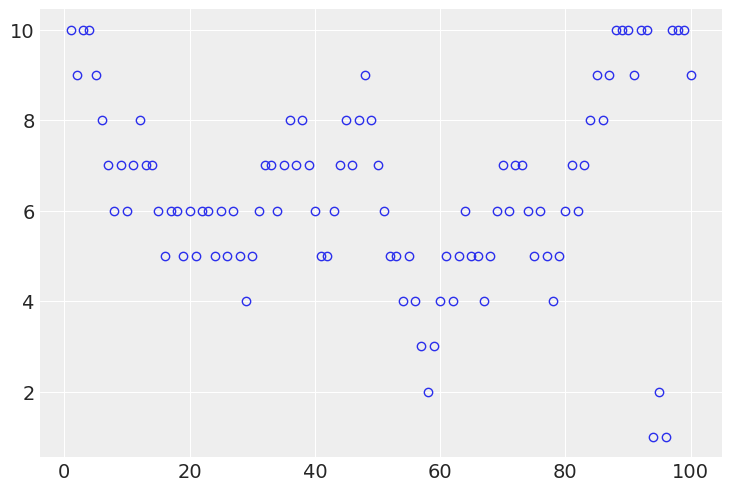

In [3]:
plt.plot(range(1, 101), positions[:100], "o", mfc="none")
plt.show()

### Code 9.3

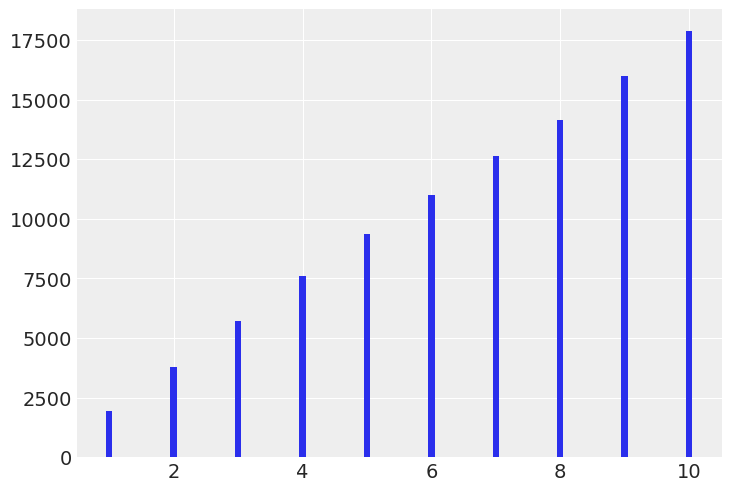

In [4]:
plt.hist(positions, bins=range(1, 12), rwidth=0.1, align="left")
plt.show()

### Code 9.4

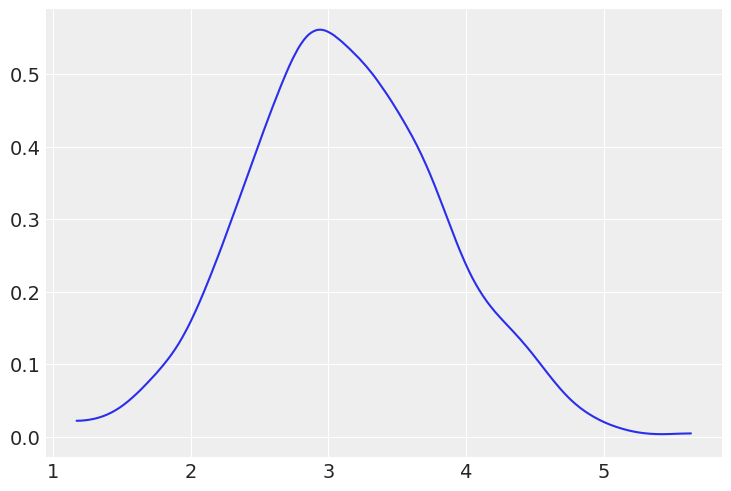

In [5]:
D = 10
T = int(1e3)
Y = dist.MultivariateNormal(jnp.repeat(0, D), jnp.identity(D)).sample(
    random.PRNGKey(0), (T,)
)
rad_dist = lambda Y: jnp.sqrt(jnp.sum(Y ** 2))
Rd = lax.map(lambda i: rad_dist(Y[i]), jnp.arange(T))
az.plot_kde(Rd, bw=0.18)
plt.show()

### Code 9.5

In [6]:
# U needs to return neg-log-probability
def U(q, a=0, b=1, k=0, d=1):
    muy = q[0]
    mux = q[1]
    logprob_y = jnp.sum(dist.Normal(muy, 1).log_prob(y))
    logprob_x = jnp.sum(dist.Normal(mux, 1).log_prob(x))
    logprob_muy = dist.Normal(a, b).log_prob(muy)
    logprob_mux = dist.Normal(k, d).log_prob(mux)
    U = logprob_y + logprob_x + logprob_muy + logprob_mux
    return -U

### Code 9.6

In [7]:
# gradient function
# need vector of partial derivatives of U with respect to vector q
def U_gradient(q, a=0, b=1, k=0, d=1):
    muy = q[0]
    mux = q[1]
    G1 = jnp.sum(y - muy) + (a - muy) / b ** 2  # dU/dmuy
    G2 = jnp.sum(x - mux) + (k - mux) / b ** 2  # dU/dmux
    return jnp.stack([-G1, -G2])  # negative bc energy is neg-log-prob


# test data
with numpyro.handlers.seed(rng_seed=7):
    y = numpyro.sample("y", dist.Normal().expand([50]))
    x = numpyro.sample("x", dist.Normal().expand([50]))
    x = (x - jnp.mean(x)) / jnp.std(x)
    y = (y - jnp.mean(y)) / jnp.std(y)

### Code 9.7

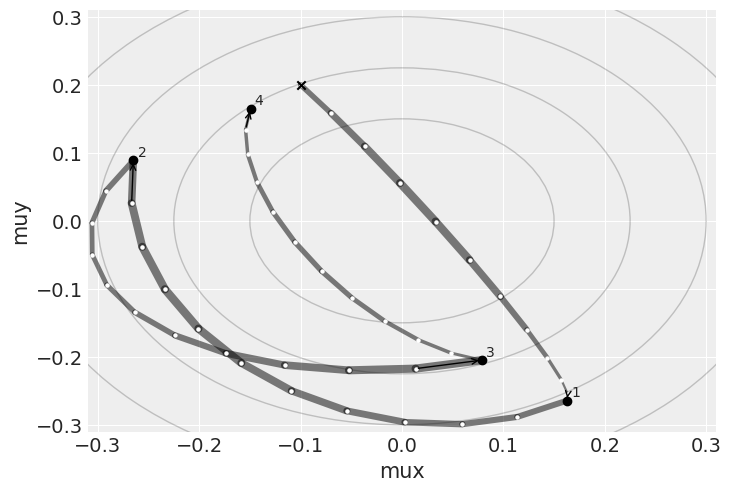

In [8]:
def HMC2(U, grad_U, epsilon, L, current_q, rng):
    q = current_q
    # random flick - p is momentum
    p = dist.Normal(0, 1).sample(random.fold_in(rng, 0), (q.shape[0],))
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = jnp.full((L + 1, q.shape[0]), jnp.nan)
    ptraj = qtraj
    qtraj = ops.index_update(qtraj, 0, current_q)
    ptraj = ops.index_update(ptraj, 0, p)

    # Alternate full steps for position and momentum
    for i in range(L):
        q = q + epsilon * p  # Full step for the position
        # Make a full step for the momentum, except at end of trajectory
        if i != (L - 1):
            p = p - epsilon * grad_U(q)
            ptraj = ops.index_update(ptraj, i + 1, p)
        qtraj = ops.index_update(qtraj, i + 1, q)

    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2
    ptraj = ops.index_update(ptraj, L, p)
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = jnp.sum(current_p ** 2) / 2
    proposed_U = U(q)
    proposed_K = jnp.sum(p ** 2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    runif = dist.Uniform().sample(random.fold_in(rng, 1))
    if runif < jnp.exp(current_U - proposed_U + current_K - proposed_K):
        new_q = q  # accept
        accept = 1
    else:
        new_q = current_q  # reject
    return {
        "q": new_q,
        "traj": qtraj,
        "ptraj": ptraj,
        "accept": accept,
        "dH": proposed_U + proposed_K - (current_U + current_K),
    }


Q = {}
Q["q"] = jnp.array([-0.1, 0.2])
pr = 0.31
plt.subplot(ylabel="muy", xlabel="mux", xlim=(-pr, pr), ylim=(-pr, pr))
step = 0.03
L = 11  # 0.03/28 for U-turns --- 11 for working example
n_samples = 4
path_col = (0, 0, 0, 0.5)
for r in 0.075 * jnp.arange(2, 6):
    plt.gca().add_artist(plt.Circle((0, 0), r, alpha=0.2, fill=False))
plt.scatter(Q["q"][0], Q["q"][1], c="k", marker="x", zorder=4)
for i in range(n_samples):
    Q = HMC2(U, U_gradient, step, L, Q["q"], random.fold_in(random.PRNGKey(0), i))
    if n_samples < 10:
        for j in range(L):
            K0 = jnp.sum(Q["ptraj"][j] ** 2) / 2
            plt.plot(
                Q["traj"][j : j + 2, 0],
                Q["traj"][j : j + 2, 1],
                c=path_col,
                lw=1 + 2 * K0,
            )
        plt.scatter(Q["traj"][:, 0], Q["traj"][:, 1], c="white", s=5, zorder=3)
        # for fancy arrows
        dx = Q["traj"][L, 0] - Q["traj"][L - 1, 0]
        dy = Q["traj"][L, 1] - Q["traj"][L - 1, 1]
        d = jnp.sqrt(dx ** 2 + dy ** 2)
        plt.annotate(
            "",
            (Q["traj"][L - 1, 0], Q["traj"][L - 1, 1]),
            (Q["traj"][L, 0], Q["traj"][L, 1]),
            arrowprops={"arrowstyle": "<-"},
        )
        plt.annotate(
            str(i + 1),
            (Q["traj"][L, 0], Q["traj"][L, 1]),
            xytext=(3, 3),
            textcoords="offset points",
        )
    plt.scatter(
        Q["traj"][L + 1, 0],
        Q["traj"][L + 1, 1],
        c=("red" if jnp.abs(Q["dH"]) > 0.1 else "black"),
        zorder=4,
    )

### Code 9.8

In [9]:
source_HMC2 = inspect.getsourcelines(HMC2)
print("".join("".join(source_HMC2[0]).split("\n\n")[0]))

def HMC2(U, grad_U, epsilon, L, current_q, rng):
    q = current_q
    # random flick - p is momentum
    p = dist.Normal(0, 1).sample(random.fold_in(rng, 0), (q.shape[0],))
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = jnp.full((L + 1, q.shape[0]), jnp.nan)
    ptraj = qtraj
    qtraj = ops.index_update(qtraj, 0, current_q)
    ptraj = ops.index_update(ptraj, 0, p)


### Code 9.9

In [10]:
print("".join("".join(source_HMC2[0]).split("\n\n")[1]))

    # Alternate full steps for position and momentum
    for i in range(L):
        q = q + epsilon * p  # Full step for the position
        # Make a full step for the momentum, except at end of trajectory
        if i != (L - 1):
            p = p - epsilon * grad_U(q)
            ptraj = ops.index_update(ptraj, i + 1, p)
        qtraj = ops.index_update(qtraj, i + 1, q)


### Code 9.10

In [11]:
print("".join("".join(source_HMC2[0]).split("\n\n")[2]))

    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2
    ptraj = ops.index_update(ptraj, L, p)
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = jnp.sum(current_p ** 2) / 2
    proposed_U = U(q)
    proposed_K = jnp.sum(p ** 2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    runif = dist.Uniform().sample(random.fold_in(rng, 1))
    if runif < jnp.exp(current_U - proposed_U + current_K - proposed_K):
        new_q = q  # accept
        accept = 1
    else:
        new_q = current_q  # reject
    return {
        "q": new_q,
        "traj": qtraj,
        "ptraj": ptraj,
        "accept": accept,
        "dH": proposed_U + proposed_K - (current_U + current_K),
    }



### Code 9.11

In [12]:
rugged = pd.read_csv("../data/rugged.csv", sep=";")
d = rugged
d["log_gdp"] = d["rgdppc_2000"].apply(math.log)
dd = d[d["rgdppc_2000"].notnull()].copy()
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()
dd["cid"] = jnp.where(dd.cont_africa.values == 1, 0, 1)

### Code 9.12

In [13]:
def model(cid, rugged_std, log_gdp_std=None):
    a = numpyro.sample("a", dist.Normal(1, 0.1).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.3).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a[cid] + b[cid] * (rugged_std - 0.215))
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)


m8_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m8_3,
    optim.Adam(0.1),
    ELBO(),
    cid=dd.cid.values,
    rugged_std=dd.rugged_std.values,
    log_gdp_std=dd.log_gdp_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p8_3 = svi.get_params(state)
post = m8_3.sample_posterior(random.PRNGKey(1), p8_3, (1000,))
print_summary({k: v for k, v in post.items() if k != "mu"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91   1009.20      1.00
      a[1]      1.05      0.01      1.05      1.04      1.07    755.33      1.00
      b[0]      0.13      0.07      0.13      0.01      0.24   1045.06      1.00
      b[1]     -0.15      0.06     -0.14     -0.23     -0.05   1003.36      1.00
     sigma      0.11      0.01      0.11      0.10      0.12    810.01      1.00



### Code 9.13

In [14]:
dat_slim = {
    "log_gdp_std": dd.log_gdp_std.values,
    "rugged_std": dd.rugged_std.values,
    "cid": dd.cid.values,
}
{k: v[:5] for k, v in dat_slim.items()}

{'log_gdp_std': array([0.87971187, 0.9647547 , 1.1662705 , 1.10448536, 0.91490375]),
 'rugged_std': array([0.13834247, 0.55256369, 0.12399226, 0.12495969, 0.43340858]),
 'cid': array([0, 1, 1, 1, 1])}

### Code 9.14

In [15]:
def model(cid, rugged_std, log_gdp_std):
    a = numpyro.sample("a", dist.Normal(1, 0.1).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.3).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)


m9_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m9_1.run(random.PRNGKey(0), **dat_slim)

sample: 100%|█| 1000/1000 [00:05<00:00, 187.61it/s, 3 steps of size 8.51e-01. a


### Code 9.15

In [16]:
m9_1.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.89      0.01      0.89      0.87      0.91    620.74      1.00
      a[1]      1.05      0.01      1.05      1.04      1.07    653.73      1.00
      b[0]      0.13      0.07      0.13      0.02      0.25    529.54      1.00
      b[1]     -0.14      0.05     -0.15     -0.23     -0.06    475.34      1.00
     sigma      0.11      0.01      0.11      0.10      0.12    701.55      1.00

Number of divergences: 0


### Code 9.16

In [17]:
def model(cid, rugged_std, log_gdp_std):
    a = numpyro.sample("a", dist.Normal(1, 0.1).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.3).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)


m9_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m9_1.run(random.PRNGKey(0), **dat_slim)

### Code 9.17

In [18]:
print("".join(inspect.getsourcelines(m9_1.sampler.model)[0]))

def model(cid, rugged_std, log_gdp_std):
    a = numpyro.sample("a", dist.Normal(1, 0.1).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.3).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)



### Code 9.18

In [19]:
m9_1.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91   2373.86      1.00
      a[1]      1.05      0.01      1.05      1.03      1.07   2488.81      1.00
      b[0]      0.13      0.08      0.13      0.01      0.25   2338.01      1.00
      b[1]     -0.14      0.05     -0.14     -0.23     -0.06   2509.65      1.00
     sigma      0.11      0.01      0.11      0.10      0.12   2328.20      1.00

Number of divergences: 0


### Code 9.19

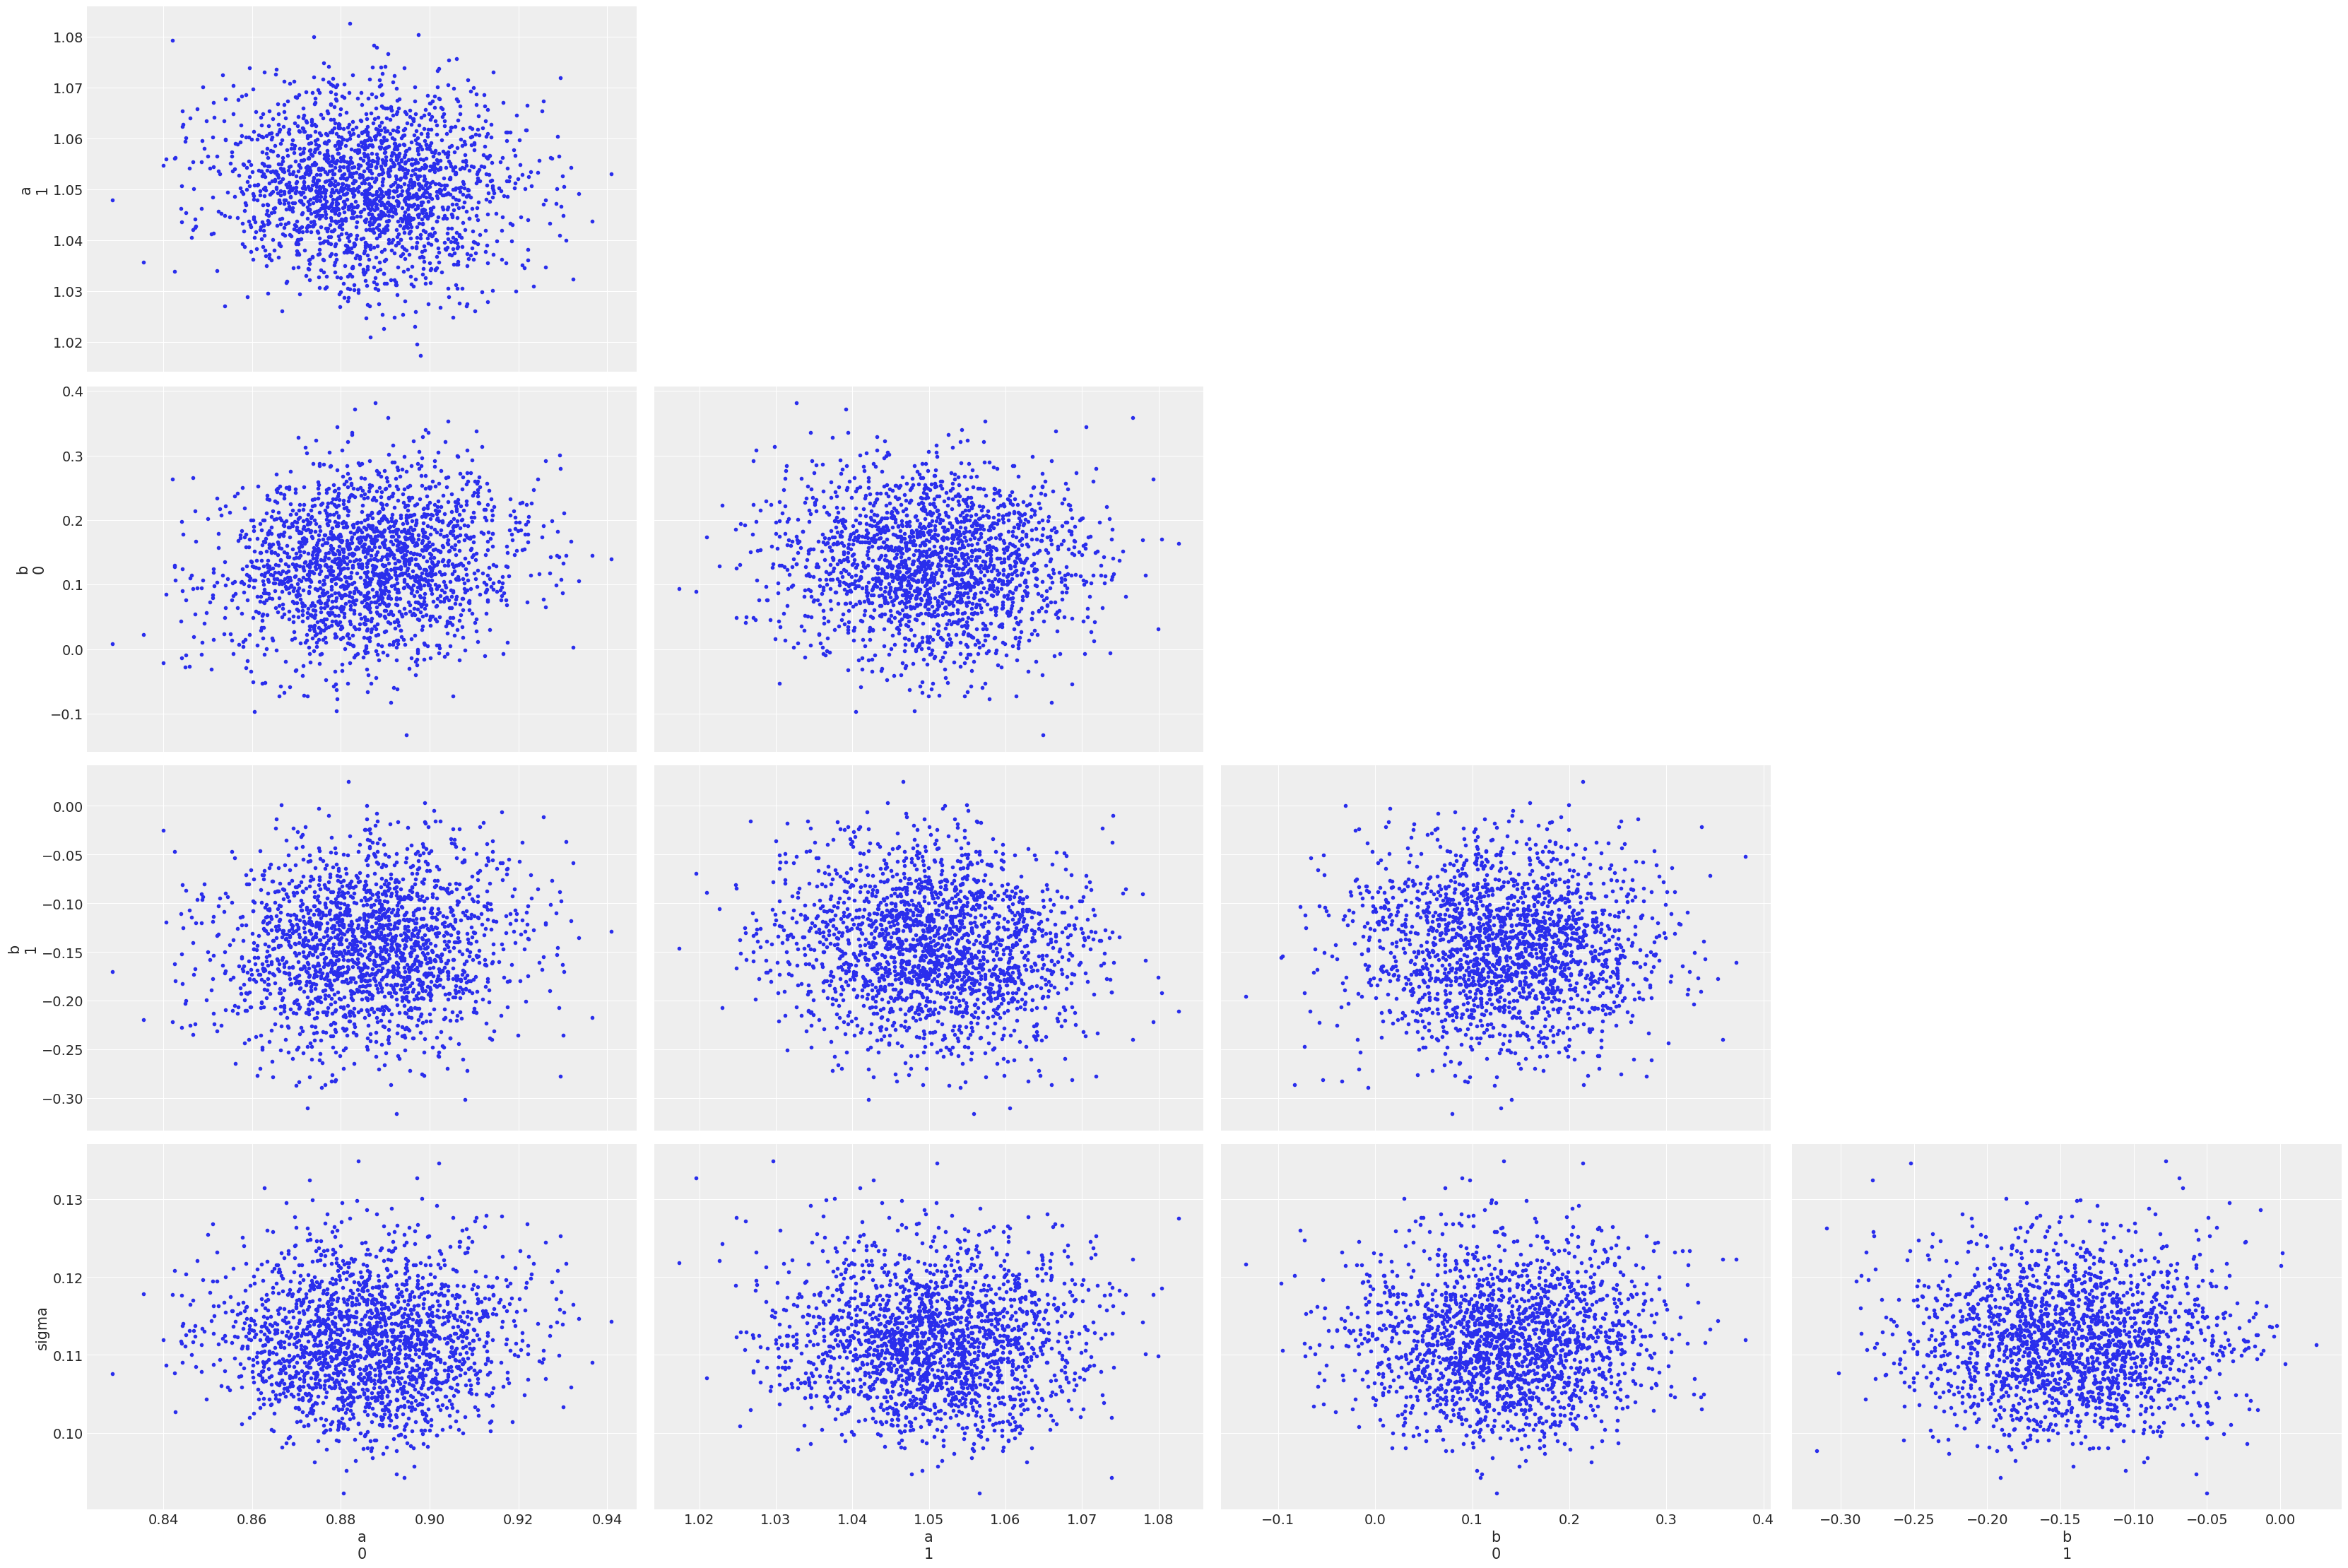

In [20]:
az.plot_pair(az.from_numpyro(m9_1))
plt.show()

### Code 9.20

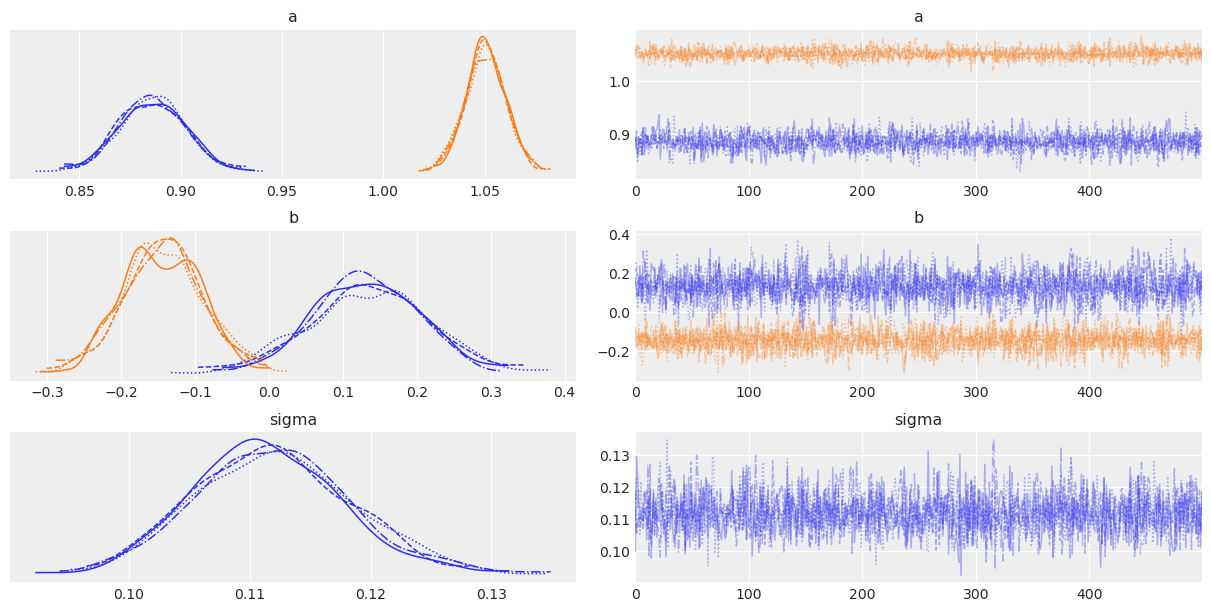

In [21]:
az.plot_trace(az.from_numpyro(m9_1))
plt.show()

### Code 9.21

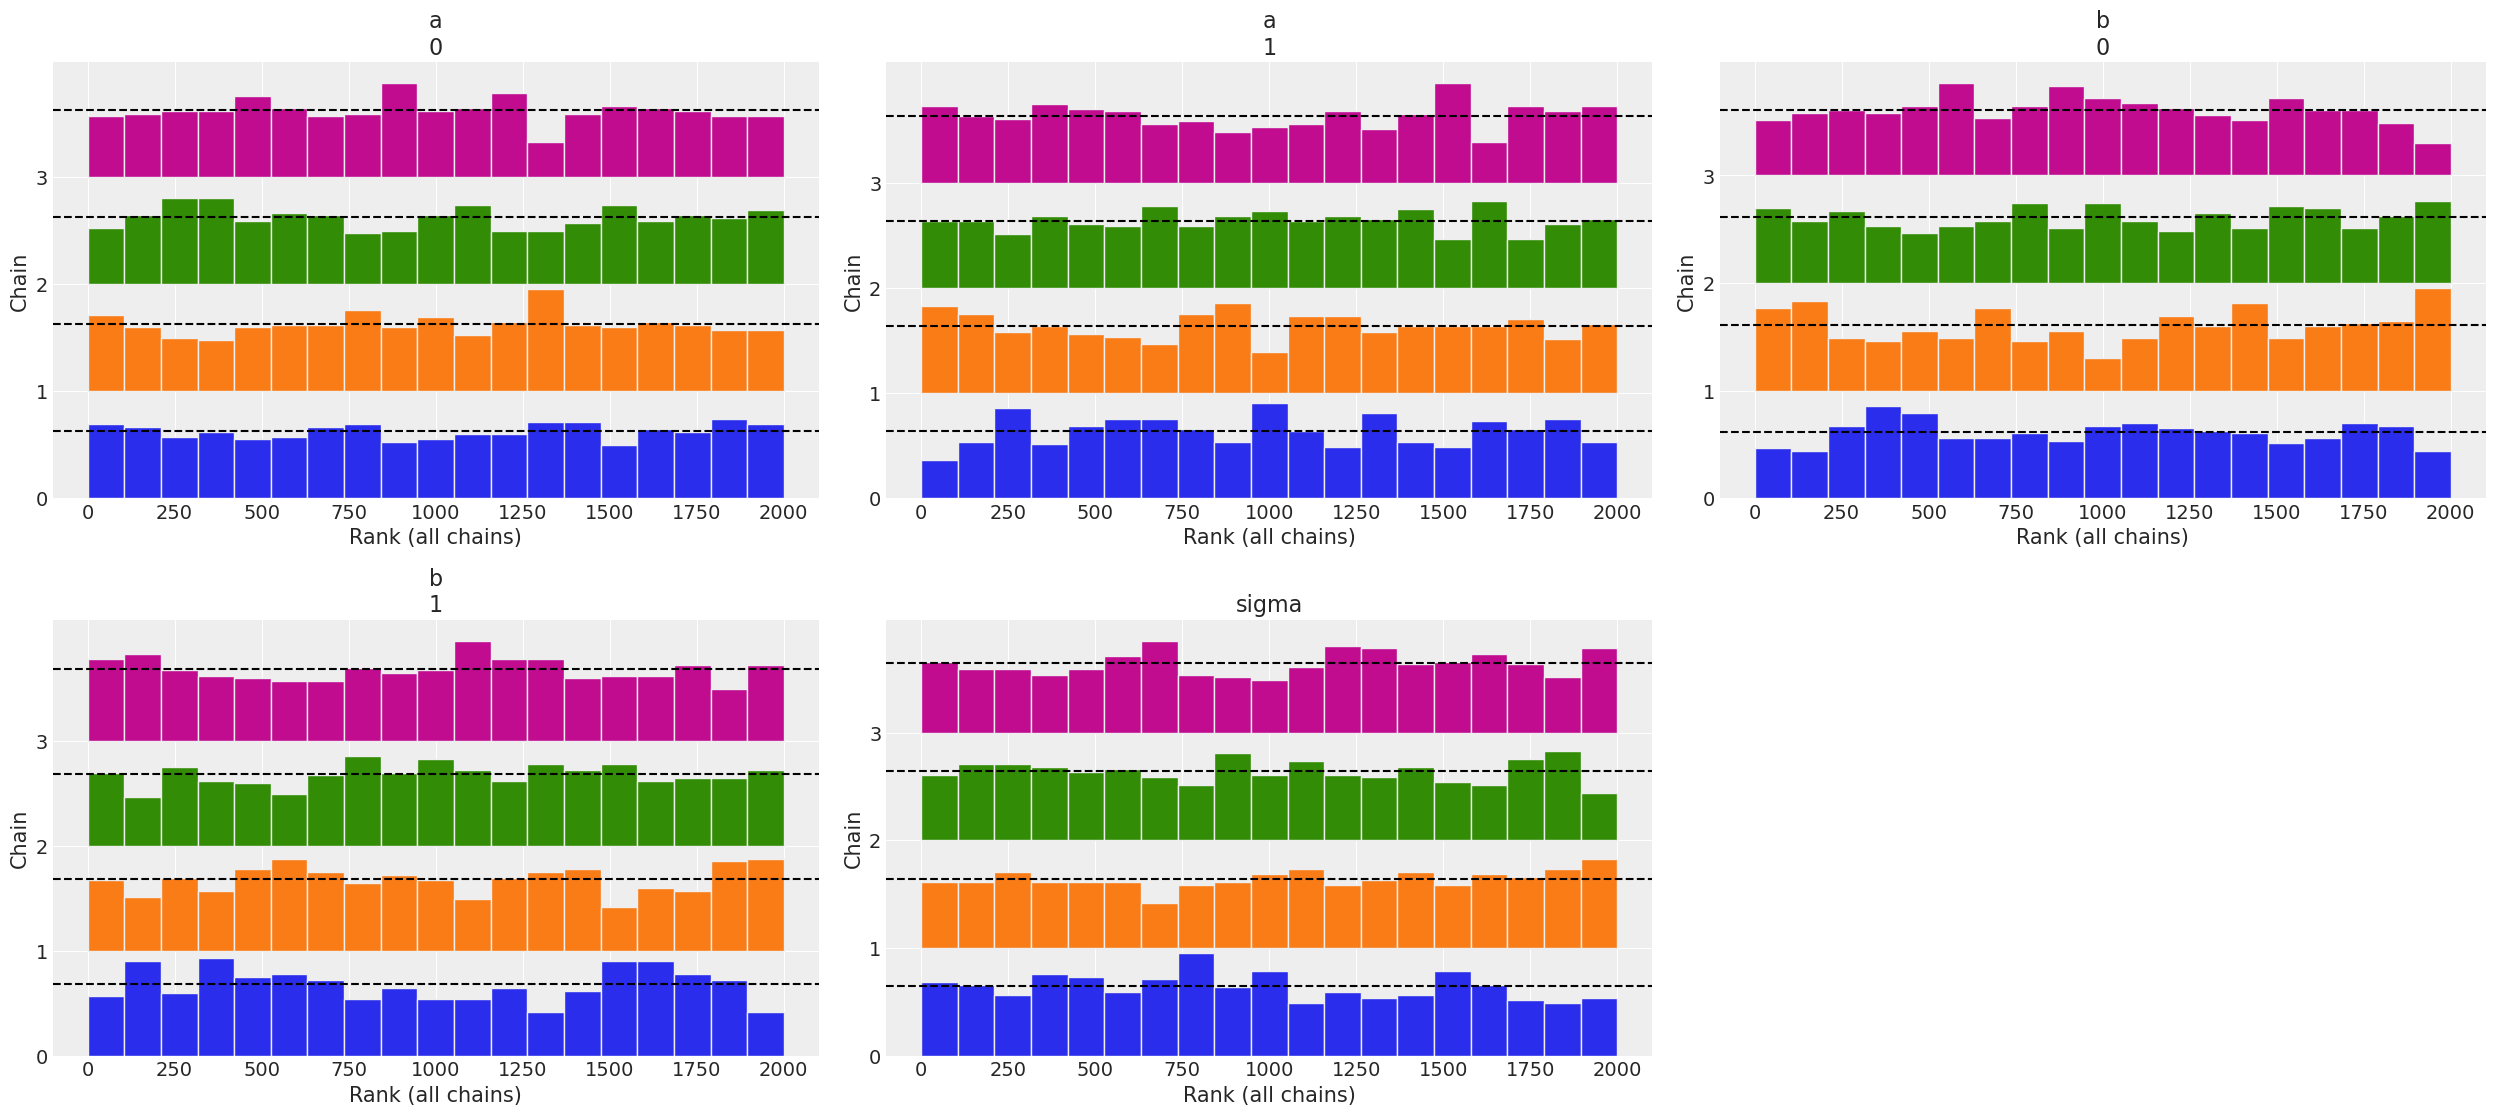

In [22]:
az.plot_rank(az.from_numpyro(m9_1))
plt.show()

### Code 9.22

In [23]:
y = jnp.array([-1, 1])


def model(y):
    alpha = numpyro.sample("alpha", dist.Normal(0, 1000))
    sigma = numpyro.sample("sigma", dist.Exponential(0.0001))
    mu = alpha
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


m9_2 = MCMC(
    NUTS(model, target_accept_prob=0.95), num_warmup=500, num_samples=500, num_chains=3
)
m9_2.run(random.PRNGKey(11), y=y)

### Code 9.23

In [24]:
m9_2.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     alpha    -31.11    344.55     -0.67   -634.04    376.59    196.67      1.02
     sigma    611.71   1269.01    174.34      1.93   1483.19    196.91      1.02

Number of divergences: 64


### Code 9.24

In [25]:
y = jnp.array([-1, 1])


def model(y):
    alpha = numpyro.sample("alpha", dist.Normal(1, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = alpha
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


m9_3 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=3)
m9_3.run(random.PRNGKey(11), y=y)
m9_3.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     alpha      0.11      1.43      0.07     -1.84      2.38    267.56      1.01
     sigma      1.64      0.94      1.39      0.57      2.87    388.92      1.00

Number of divergences: 3


### Code 9.25

In [26]:
y = dist.Normal(loc=0, scale=1).sample(random.PRNGKey(41), (100,))

### Code 9.26

In [27]:
def model(y):
    a1 = numpyro.sample("a1", dist.Normal(0, 1000))
    a2 = numpyro.sample("a2", dist.Normal(0, 1000))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a1 + a2
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


m9_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=3)
m9_4.run(random.PRNGKey(384), extra_fields=["num_steps"], y=y)
m9_4.print_summary()
print(
    "There were {} transitions that exceeded the maximum treedepth.".format(
        (m9_4.get_extra_fields()["num_steps"] + 1 == 2 ** 10).sum()
    )
)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a1     39.31    852.18   -275.94  -1135.61   1443.43      1.70      5.44
        a2    -39.20    852.17    276.14  -1443.22   1135.67      1.70      5.44
     sigma      1.13      0.07      1.13      1.02      1.23      9.37      1.23

Number of divergences: 0
There were 1087 transitions that exceeded the maximum treedepth.


### Code 9.27

In [28]:
def model(y):
    a1 = numpyro.sample("a1", dist.Normal(0, 10))
    a2 = numpyro.sample("a2", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a1 + a2
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


m9_5 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=3)
m9_5.run(random.PRNGKey(0), y=y)
m9_5.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        a1      0.75      7.31      0.97    -11.86     11.57    379.59      1.00
        a2     -0.63      7.31     -0.88    -11.42     12.00    379.36      1.00
     sigma      1.15      0.08      1.15      1.01      1.28    410.56      1.00

Number of divergences: 0


### Code 9.28

In [29]:
def model(y):
    numpyro.sample("a", dist.Normal(0, 1))
    numpyro.sample("b", dist.Cauchy(0, 1))


kernel = NUTS(model, init_strategy=init_to_value(values={"a": 0.0, "b": 0.0}))
mp = MCMC(kernel, num_warmup=100, num_samples=9900)
mp.run(random.PRNGKey(0), y=1)

sample: 100%|█| 10000/10000 [00:11<00:00, 873.73it/s, 7 steps of size 4.81e-01.


### Code 9.29

In [30]:
N = 100  # number of individuals
# sim total height of each
height = dist.Normal(10, 2).sample(random.PRNGKey(0), (N,))
# leg as proportion of height
leg_prop = dist.Uniform(0.4, 0.5).sample(random.PRNGKey(1), (N,))
# sim left leg as proportion + error
leg_left = leg_prop * height + dist.Normal(0, 0.02).sample(random.PRNGKey(2), (N,))
# sim right leg as proportion + error
leg_right = leg_prop * height + dist.Normal(0, 0.02).sample(random.PRNGKey(3), (N,))
# combine into data frame
d = pd.DataFrame({"height": height, "leg_left": leg_left, "leg_right": leg_right})


def model(leg_left, leg_right, height):
    a = numpyro.sample("a", dist.Normal(10, 100))
    bl = numpyro.sample("bl", dist.Normal(2, 10))
    br = numpyro.sample("br", dist.Normal(2, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bl * leg_left + br * leg_right
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


kernel = NUTS(
    model,
    init_strategy=init_to_value(values={"a": 10.0, "bl": 0.0, "br": 0.1, "sigma": 1.0}),
)
m5_8s = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4)
m5_8s.run(random.PRNGKey(0), **dict(zip(d.columns, d.T.values)))

### Code 9.30

In [31]:
def model(leg_left, leg_right, height):
    a = numpyro.sample("a", dist.Normal(10, 100))
    bl = numpyro.sample("bl", dist.Normal(2, 10))
    br = numpyro.sample("br", dist.TruncatedNormal(0, 2, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bl * leg_left + br * leg_right
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


kernel = NUTS(
    model,
    init_strategy=init_to_value(values={"a": 10.0, "bl": 0.0, "br": 0.1, "sigma": 1.0}),
)
m5_8s2 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4)
m5_8s2.run(random.PRNGKey(0), **dict(zip(d.columns, d.T.values)))